In [95]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score, auc, roc_auc_score,roc_curve

In [96]:
df=pd.read_csv('bank-full.csv',delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [97]:
chosen_columns=['age','job','marital','education','balance','housing','contact',
                'day','month','duration','campaign','pdays','previous','poutcome','y']

In [98]:
df=df[chosen_columns]
df.y = (df.y == 'yes').astype(int)

In [99]:
from sklearn.model_selection import train_test_split
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [109]:
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [127]:
len(df_train_full), len(df_train), len(df_val), len(df_test)

(36168, 27126, 9042, 9043)

In [124]:
numerical=['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical=['job', 'marital', 'education', 'housing', 'contact', 'month','poutcome']

### Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- balance
- day
- duration
- previous

In [112]:
df_train[numerical].head(1)

,age,balance,day,duration,campaign,pdays,previous
0,56,40,11,123,2,-1,0


In [113]:
fpr, tpr, thresholds = roc_curve(y,df_train['age'])
roc_auc_score(y,df_train['age']), auc(fpr, tpr)


(np.float64(0.48781428247265596), np.float64(0.48781428247265596))

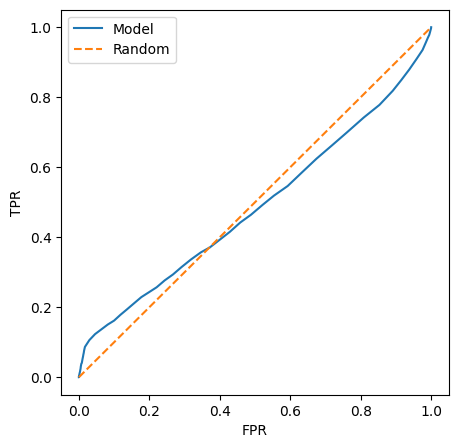

In [114]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [115]:
for score in df_train[numerical]:#
    area_under_curve=roc_auc_score(y,df_train[score])
    if area_under_curve<0.5:
        area_under_curve=roc_auc_score(y,-df_train[score])
    print(score, area_under_curve)

age 0.512185717527344
balance 0.5888313805382317
day 0.525957882383908
duration 0.8147002759670778
campaign 0.5714543015682159
pdays 0.5901276247352144
previous 0.5985653242764153


Which numerical variable (among the following 4) has the highest AUC?

* balance
* day
* duration
* previous

In [116]:
# duration

### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

In [118]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [129]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [130]:
len(y_pred)

9042

In [131]:
roc_auc_score(y_val, y_pred),

(np.float64(0.9006884713944792),)

In [134]:
#roc_auc_score(y_pred, y_val)